In [4]:
#Start Spark Session
from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.types import NumericType, DoubleType, FloatType

# If a stale session exists, stop safely
try:
    spark.stop()
except:
    pass

spark = (
    SparkSession.builder
      .appName("Colab_Spark_EDA_ML_MapReduce")
      .master("local[*]")
      .config("spark.driver.memory", "4g")
      .config("spark.sql.shuffle.partitions", "200")
      .config("spark.ui.showConsoleProgress", "false")
      .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")
print("Spark version:", spark.version)

Spark version: 3.5.1


In [5]:
#Load data
import time

t0 = time.time()
df = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .option("mode", "DROPMALFORMED")
    .csv("/content/drive/MyDrive/Bigdata.csv.csv")
)
load_secs = time.time() - t0
print("Rows:", df.count(), "| Load secs:", round(load_secs, 2))
df.printSchema()
df.show(10, truncate=False)


Rows: 4023022 | Load secs: 30.14
root
 |-- id: integer (nullable = true)
 |-- time: double (nullable = true)
 |-- xloc_kf: double (nullable = true)
 |-- yloc_kf: double (nullable = true)
 |-- lane_kf: integer (nullable = true)
 |-- speed_kf: double (nullable = true)
 |-- acceleration_kf: double (nullable = true)
 |-- length_smoothed: double (nullable = true)
 |-- width_smoothed: double (nullable = true)
 |-- type_most_common: string (nullable = true)
 |-- av: string (nullable = true)
 |-- run_index: integer (nullable = true)

+---+----+----------+----------+-------+--------+---------------+---------------+--------------+----------------+---+---------+
|id |time|xloc_kf   |yloc_kf   |lane_kf|speed_kf|acceleration_kf|length_smoothed|width_smoothed|type_most_common|av |run_index|
+---+----+----------+----------+-------+--------+---------------+---------------+--------------+----------------+---+---------+
|57 |8.2 |378.572421|211.69428 |2      |4.71776 |1.13           |5.39           |2.6

In [6]:
# Normalize columns (lowercase, spaces/dots -> underscores)
def normalize_col(c: str) -> str:
    return c.strip().lower().replace(" ", "_").replace(".", "_")

old_cols = df.columns
df = df.toDF(*[normalize_col(c) for c in old_cols])

# Null counts
null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(f"{c}_nulls") for c in df.columns])
null_counts.show(truncate=False)

# Numeric vs categorical
num_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
cat_cols = [c for c in df.columns if c not in num_cols]
print("Numeric columns:", num_cols[:20], "..." if len(num_cols)>20 else "")
print("Categorical columns:", cat_cols[:20], "..." if len(cat_cols)>20 else "")

# Summary stats
if num_cols:
    df.select(num_cols).summary("count","min","25%","50%","75%","max","mean","stddev").show(truncate=False)


+--------+----------+-------------+-------------+-------------+--------------+---------------------+---------------------+--------------------+----------------------+--------+---------------+
|id_nulls|time_nulls|xloc_kf_nulls|yloc_kf_nulls|lane_kf_nulls|speed_kf_nulls|acceleration_kf_nulls|length_smoothed_nulls|width_smoothed_nulls|type_most_common_nulls|av_nulls|run_index_nulls|
+--------+----------+-------------+-------------+-------------+--------------+---------------------+---------------------+--------------------+----------------------+--------+---------------+
|0       |0         |0            |0            |0            |0             |0                    |0                    |0                   |0                     |0       |0              |
+--------+----------+-------------+-------------+-------------+--------------+---------------------+---------------------+--------------------+----------------------+--------+---------------+

Numeric columns: ['id', 'time', 'xloc_k

In [7]:
##Cleaning, filtering, feature engineering
df1 = df.dropDuplicates()
print("Rows after dropDuplicates:", df1.count())

# Try to create a normalized type column if a likely source exists
candidate_type_cols = ["type_most_common","type","vehicle_type","veh_type","class","category"]
found_type = next((c for c in candidate_type_cols if c in df1.columns), None)
if found_type:
    df1 = df1.withColumn("type_norm", F.trim(F.lower(F.col(found_type))))
    print("Created type_norm from:", found_type)
else:
    print("No obvious type column found.")

# Filter unrealistic speed range if present (0–60 m/s ~ up to ~216 km/h)
if "speed_kf" in df1.columns:
    df1 = df1.filter((F.col("speed_kf") >= 0) & (F.col("speed_kf") <= 60))
    print("Applied speed_kf filter [0, 60].")

# Derived features
if {"xloc_kf","yloc_kf"}.issubset(df1.columns):
    df1 = df1.withColumn("distance_from_origin", F.sqrt(F.col("xloc_kf")**2 + F.col("yloc_kf")**2))

if {"speed_kf","acceleration_kf"}.issubset(df1.columns):
    df1 = df1.withColumn("kinetic_indicator", F.col("speed_kf") * (1 + F.col("acceleration_kf")))

df1.cache()
print("Rows after transforms:", df1.count())
df1.printSchema()


Rows after dropDuplicates: 4023022
Created type_norm from: type_most_common
Applied speed_kf filter [0, 60].
Rows after transforms: 4023022
root
 |-- id: integer (nullable = true)
 |-- time: double (nullable = true)
 |-- xloc_kf: double (nullable = true)
 |-- yloc_kf: double (nullable = true)
 |-- lane_kf: integer (nullable = true)
 |-- speed_kf: double (nullable = true)
 |-- acceleration_kf: double (nullable = true)
 |-- length_smoothed: double (nullable = true)
 |-- width_smoothed: double (nullable = true)
 |-- type_most_common: string (nullable = true)
 |-- av: string (nullable = true)
 |-- run_index: integer (nullable = true)
 |-- type_norm: string (nullable = true)
 |-- distance_from_origin: double (nullable = true)
 |-- kinetic_indicator: double (nullable = true)



In [8]:
#Aggregations
import time

group_cols = []
if "lane_kf" in df1.columns: group_cols.append("lane_kf")
if "type_norm" in df1.columns: group_cols.append("type_norm")

if group_cols:
    t0 = time.time()
    agg_df = (
        df1.groupBy(*group_cols)
           .agg(
               F.count("*").alias("n"),
               F.avg("speed_kf").alias("avg_speed"),
               F.stddev("speed_kf").alias("std_speed"),
               F.avg("acceleration_kf").alias("avg_accel"),
               F.avg("length_smoothed").alias("avg_len"),
               F.avg("width_smoothed").alias("avg_wid"),
           )
           .orderBy(F.desc("n"))
    )
    print("Aggregation runtime (s):", round(time.time() - t0, 2))
    agg_df.show(50, truncate=False)
else:
    print("No grouping columns found; computing global averages for numeric columns.")
    if num_cols:
        df1.select([F.avg(c).alias(f"avg_{c}") for c in num_cols]).show(truncate=False)

Aggregation runtime (s): 0.1
+-------+-------------+------+------------------+------------------+---------------------+------------------+------------------+
|lane_kf|type_norm    |n     |avg_speed         |std_speed         |avg_accel            |avg_len           |avg_wid           |
+-------+-------------+------+------------------+------------------+---------------------+------------------+------------------+
|11     |small-vehicle|690022|4.922661253887558 |2.7393667057963893|-0.010711281669280107|5.512620133850798 |2.4958981452765494|
|10     |small-vehicle|651823|5.688508815752129 |3.006716097275051 |-0.013058683108758061|5.551518326294103 |2.503349375520678 |
|12     |small-vehicle|614332|4.433786243757444 |2.7761499360338946|-0.01852156488673877 |5.491908691066052 |2.4805956551180826|
|15     |small-vehicle|336755|14.161708455910086|3.9934634694682147|-0.08422188237739602 |5.405230835473868 |2.436784665409573 |
|14     |small-vehicle|333728|13.522208430038827|3.233242431182804 |

In [9]:
##Window functions (time-ordered per id)
df2 = df1
if {"id","time"}.issubset(df1.columns):
    w = Window.partitionBy("id").orderBy(F.col("time").cast("double"))
    df2 = (
        df1
        .withColumn("speed_prev",  F.lag("speed_kf").over(w))
        .withColumn("speed_change", F.col("speed_kf") - F.col("speed_prev"))
        .withColumn("accel_prev",  F.lag("acceleration_kf").over(w))
        .withColumn("accel_change", F.col("acceleration_kf") - F.col("accel_prev"))
    )
    df2.select("id","time","speed_kf","speed_prev","speed_change",
               "acceleration_kf","accel_prev","accel_change").show(10, truncate=False)
else:
    print("No (id,time) columns; skipping window features.")

+---+----+--------+----------+---------------------+---------------+----------+-------------------+
|id |time|speed_kf|speed_prev|speed_change         |acceleration_kf|accel_prev|accel_change       |
+---+----+--------+----------+---------------------+---------------+----------+-------------------+
|26 |4.3 |8.16811 |NULL      |NULL                 |-0.22          |NULL      |NULL               |
|26 |4.4 |8.14634 |8.16811   |-0.021770000000000067|0.58           |-0.22     |0.7999999999999999 |
|26 |4.5 |8.20437 |8.14634   |0.05803000000000047  |-0.49          |0.58      |-1.0699999999999998|
|26 |4.6 |8.15508 |8.20437   |-0.049290000000000944|0.72           |-0.49     |1.21               |
|26 |4.7 |8.22742 |8.15508   |0.07234000000000052  |-0.77          |0.72      |-1.49              |
|26 |4.8 |8.1502  |8.22742   |-0.07722000000000051 |1.0            |-0.77     |1.77               |
|26 |4.9 |8.24974 |8.1502    |0.0995399999999993   |-0.97          |1.0       |-1.97              |


Plot columns: ['speed_kf', 'acceleration_kf', 'length_smoothed', 'width_smoothed', 'xloc_kf', 'yloc_kf']


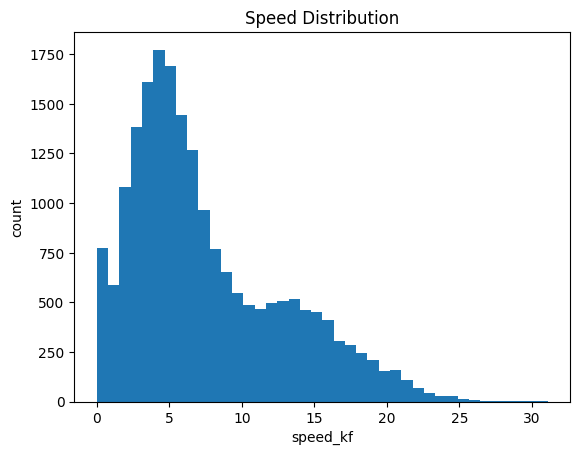

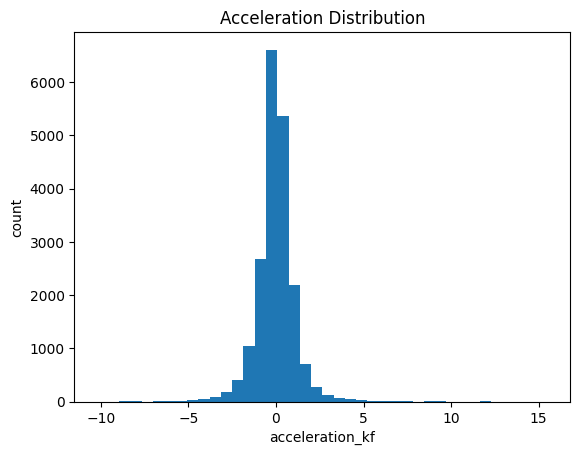

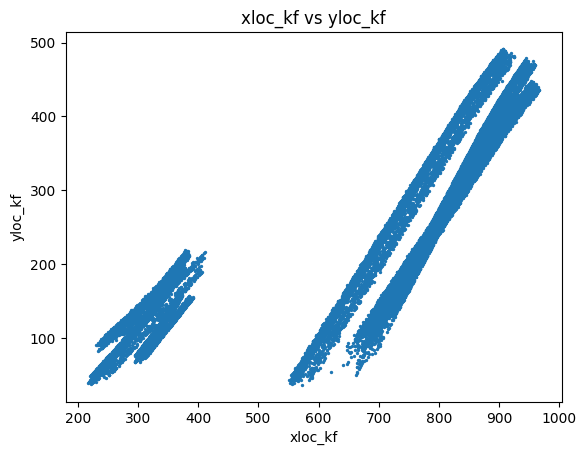

In [10]:
##Quick EDA plots (matplotlib)
import matplotlib.pyplot as plt

cols_for_plot = [c for c in ["speed_kf","acceleration_kf","length_smoothed","width_smoothed","xloc_kf","yloc_kf"] if c in df2.columns]
pdf = df2.select(*cols_for_plot).dropna().limit(20000).toPandas() if cols_for_plot else None
print("Plot columns:", cols_for_plot)

if pdf is not None and "speed_kf" in pdf.columns:
    plt.figure(); plt.hist(pdf["speed_kf"], bins=40)
    plt.title("Speed Distribution"); plt.xlabel("speed_kf"); plt.ylabel("count"); plt.show()

if pdf is not None and "acceleration_kf" in pdf.columns:
    plt.figure(); plt.hist(pdf["acceleration_kf"], bins=40)
    plt.title("Acceleration Distribution"); plt.xlabel("acceleration_kf"); plt.ylabel("count"); plt.show()

if pdf is not None and {"xloc_kf","yloc_kf"}.issubset(pdf.columns):
    plt.figure(); plt.scatter(pdf["xloc_kf"], pdf["yloc_kf"], s=2)
    plt.title("xloc_kf vs yloc_kf"); plt.xlabel("xloc_kf"); plt.ylabel("yloc_kf"); plt.show()


================ REGRESSION: Predict speed_kf ================

Features: ['length_smoothed', 'width_smoothed', 'lane_kf', 'xloc_kf', 'yloc_kf', 'speed_prev', 'accel_prev', 'speed_change', 'accel_change', 'acceleration_kf']
RMSE: 0.5731 | R²: 0.9881
Top feature importances:
  speed_prev: 0.6458
  lane_kf: 0.2346
  speed_change: 0.0899
  xloc_kf: 0.0129
  yloc_kf: 0.0060
  width_smoothed: 0.0053
  length_smoothed: 0.0033
  accel_change: 0.0008
  accel_prev: 0.0008
  acceleration_kf: 0.0005


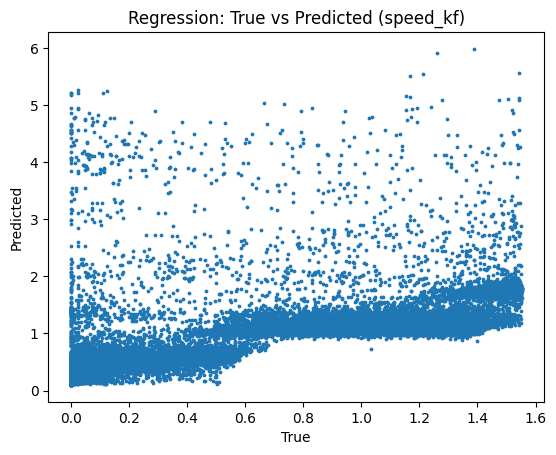

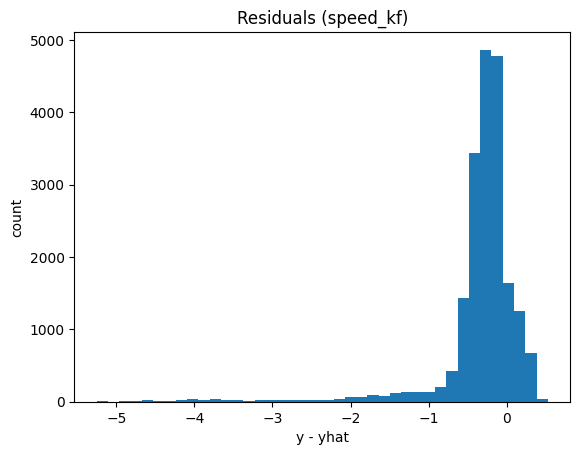

Insight: Lower RMSE / higher R² = better predictions; top features signal operational drivers of speed.


================ CLUSTERING: KMeans (auto-k selection 3..6) ================

Clustering features: ['speed_kf', 'acceleration_kf', 'length_smoothed', 'width_smoothed', 'xloc_kf', 'yloc_kf']
k=3 -> silhouette=0.4805
k=4 -> silhouette=0.3937
k=5 -> silhouette=0.4210
k=6 -> silhouette=0.3914
Chosen k = 3 (silhouette=0.4805)
+-------+-------+
|cluster|  count|
+-------+-------+
|      0|1527199|
|      1|  70464|
|      2|2425359|
+-------+-------+



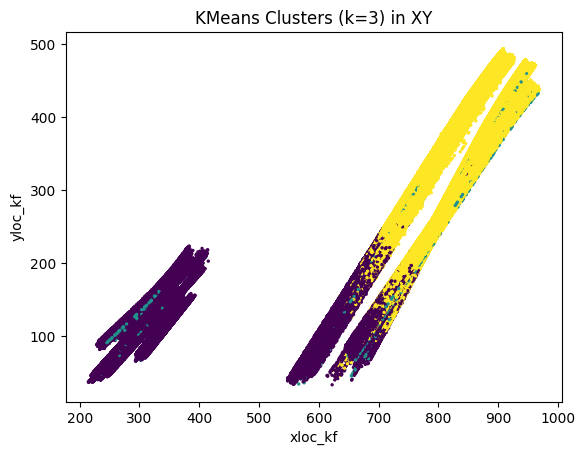

Insight: Cluster sizes and separation indicate natural segments; use to tailor policies or monitoring.



In [16]:
# =========================
# MLlib: Regression, Classification, Clustering
# (defensive, Colab-ready, with evaluation & visuals)
# =========================

from pyspark.sql import functions as F, Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, PCA as PCAml
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import (
    RegressionEvaluator,
    MulticlassClassificationEvaluator,
    ClusteringEvaluator,
)
from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt

# ---------- sanity: spark & df ----------
try:
    spark.version
except Exception:
    from pyspark.sql import SparkSession
    spark = (SparkSession.builder
             .appName("Colab_Spark_Recover")
             .master("local[*]")
             .config("spark.driver.memory", "4g")
             .getOrCreate())
    spark.sparkContext.setLogLevel("WARN")
    print("Recreated Spark session:", spark.version)

if "df" not in globals():
    raise RuntimeError("`df` (preprocessed DataFrame) not found. Please run your load/preprocess cells first.")

# ---------- helpers ----------
def existing(cols):
    return [c for c in cols if c in df.columns]

def safe_count(dframe):
    try:
        return dframe.count()
    except Exception:
        return 0

def to_small_pandas(dframe, cols, n=20000):
    try:
        return dframe.select(*cols).dropna().limit(n).toPandas()
    except Exception:
        return None

def ensure_two_classes(dframe, label_col):
    try:
        return dframe.select(label_col).distinct().count() >= 2
    except Exception:
        return False

# ---------- (A) REGRESSION: predict speed_kf if available ----------
if "speed_kf" in df.columns:
    print("\n================ REGRESSION: Predict speed_kf ================\n")
    reg_features_pool = [
        "distance_from_origin","kinetic_indicator","length_smoothed","width_smoothed",
        "lane_kf","xloc_kf","yloc_kf","speed_prev","accel_prev","speed_change","accel_change",
        "acceleration_kf"  # often predictive for speed
    ]
    reg_features = existing(reg_features_pool)
    if len(reg_features) < 1:
        print("[skip] No regression features present.")
    else:
        data_reg = df.select(["speed_kf"] + reg_features).dropna()
        n_reg = safe_count(data_reg)
        if n_reg < 200:
            print(f"[skip] Not enough rows for regression (have {n_reg}, need >= 200).")
        else:
            print("Features:", reg_features)
            # Pipeline: assemble -> scale -> RF
            va = VectorAssembler(inputCols=reg_features, outputCol="feat", handleInvalid="skip")
            scaler = StandardScaler(inputCol="feat", outputCol="features", withStd=True, withMean=True)
            rf = RandomForestRegressor(featuresCol="features", labelCol="speed_kf",
                                       numTrees=120, maxDepth=12, seed=42)
            pipe = Pipeline(stages=[va, scaler, rf])

            # Split & train
            train, test = data_reg.randomSplit([0.8, 0.2], seed=42)
            if safe_count(test) == 0:
                print("[skip] Test split empty; using 90/10 split.")
                train, test = data_reg.randomSplit([0.9, 0.1], seed=42)

            model = pipe.fit(train)
            preds = model.transform(test)

            # Evaluate
            rmse = RegressionEvaluator(labelCol="speed_kf", predictionCol="prediction", metricName="rmse").evaluate(preds)
            r2   = RegressionEvaluator(labelCol="speed_kf", predictionCol="prediction", metricName="r2").evaluate(preds)
            print(f"RMSE: {rmse:.4f} | R²: {r2:.4f}")

            # Feature importances (from final RF stage)
            rf_stage = model.stages[-1]
            importances = rf_stage.featureImportances.toArray()
            fi = sorted(zip(reg_features, importances), key=lambda x: x[1], reverse=True)
            print("Top feature importances:")
            for n, v in fi[:10]:
                print(f"  {n}: {v:.4f}")

            # Visuals: true vs predicted & residuals
            ppdf = to_small_pandas(preds, [F.col("speed_kf").alias("y"), F.col("prediction").alias("yhat")], n=20000)
            if ppdf is not None and len(ppdf) > 0:
                plt.figure(); plt.scatter(ppdf["y"], ppdf["yhat"], s=3)
                plt.title("Regression: True vs Predicted (speed_kf)")
                plt.xlabel("True"); plt.ylabel("Predicted"); plt.show()

                resid = ppdf["y"] - ppdf["yhat"]
                plt.figure(); plt.hist(resid, bins=40)
                plt.title("Residuals (speed_kf)"); plt.xlabel("y - yhat"); plt.ylabel("count"); plt.show()

            print("Insight: Lower RMSE / higher R² = better predictions; top features signal operational drivers of speed.\n")

# ---------- (B) CLASSIFICATION: predict type_norm if available ----------
if "type_norm" in df.columns:
    print("\n================ CLASSIFICATION: Predict type_norm ================\n")
    cls_features_pool = [
        "distance_from_origin","kinetic_indicator","length_smoothed","width_smoothed",
        "lane_kf","xloc_kf","yloc_kf","speed_kf","acceleration_kf","speed_change","accel_change"
    ]
    cls_features = existing(cls_features_pool)
    if len(cls_features) < 1:
        print("[skip] No classification features present.")
    else:
        # Label index
        indexer = StringIndexer(inputCol="type_norm", outputCol="label", handleInvalid="skip")
        df_idx = indexer.fit(df).transform(df)
        data_cls = df_idx.select(["label"] + cls_features).dropna()
        n_cls = safe_count(data_cls)
        if n_cls < 200:
            print(f"[skip] Not enough rows for classification (have {n_cls}, need >= 200).")
        elif not ensure_two_classes(data_cls, "label"):
            print("[skip] Only one class found in label; need at least 2.")
        else:
            print("Features:", cls_features)
            # Pipeline: assemble -> scale -> RF classifier
            va = VectorAssembler(inputCols=cls_features, outputCol="feat", handleInvalid="skip")
            scaler = StandardScaler(inputCol="feat", outputCol="features", withStd=True, withMean=True)
            clf = RandomForestClassifier(featuresCol="features", labelCol="label",
                                         numTrees=150, maxDepth=12, seed=42)
            pipe = Pipeline(stages=[va, scaler, clf])

            train, test = data_cls.randomSplit([0.8, 0.2], seed=42)
            if safe_count(test) == 0:
                print("[warn] Test split empty; switching to 90/10.")
                train, test = data_cls.randomSplit([0.9, 0.1], seed=42)

            model = pipe.fit(train)
            preds = model.transform(test)

            # Metrics
            acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(preds)
            f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(preds)
            print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}")

            # Confusion matrix
            cm = preds.groupBy("label","prediction").count().orderBy("label","prediction")
            cm.show()

            # Importances
            clf_stage = model.stages[-1]
            importances = clf_stage.featureImportances.toArray()
            fi = sorted(zip(cls_features, importances), key=lambda x: x[1], reverse=True)
            print("Top feature importances:")
            for n, v in fi[:10]:
                print(f"  {n}: {v:.4f}")

            # Simple CM heatmap
            try:
                import pandas as pd
                cmp = cm.toPandas().pivot(index="label", columns="prediction", values="count").fillna(0).astype(int)
                plt.figure(); plt.imshow(cmp, aspect="auto")
                plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.colorbar(); plt.show()
            except Exception as e:
                print("[warn] Could not render confusion matrix heatmap:", e)

            print("Insight: Off-diagonal CM cells show confused classes; improve features there.\n")

# ---------- (C) CLUSTERING: KMeans on available numeric features ----------
num_pool = existing(["speed_kf","acceleration_kf","length_smoothed","width_smoothed",
                     "distance_from_origin","xloc_kf","yloc_kf"])
if len(num_pool) >= 2:
    print("\n================ CLUSTERING: KMeans (auto-k selection 3..6) ================\n")
    data_km = df.select(num_pool).dropna()
    n_km = safe_count(data_km)
    if n_km < 200:
        print(f"[skip] Not enough rows for clustering (have {n_km}, need >= 200).")
    else:
        print("Clustering features:", num_pool)
        va = VectorAssembler(inputCols=num_pool, outputCol="feat", handleInvalid="skip")
        scaler = StandardScaler(inputCol="feat", outputCol="features", withStd=True, withMean=True)
        base = Pipeline(stages=[va, scaler]).fit(data_km)
        feat = base.transform(data_km)

        # pick best k by silhouette from {3,4,5,6}
        best = None
        for k in [3,4,5,6]:
            km = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
            m = km.fit(feat)
            preds = m.transform(feat)
            sil = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette").evaluate(preds)
            print(f"k={k} -> silhouette={sil:.4f}")
            if best is None or sil > best[0]:
                best = (sil, k, m)
        sil, k_best, km_model = best
        print(f"Chosen k = {k_best} (silhouette={sil:.4f})")
        km_preds = km_model.transform(feat)
        km_preds.groupBy("cluster").count().orderBy("cluster").show()

        # Visual: prefer xloc/yloc; else PCA to 2D
        if {"xloc_kf","yloc_kf"}.issubset(km_preds.columns):
            plot_cols = ["xloc_kf","yloc_kf","cluster"]
            sub = km_preds.select(*plot_cols).sample(False, 0.1, 42).toPandas()
            plt.figure(); plt.scatter(sub["xloc_kf"], sub["yloc_kf"], c=sub["cluster"], s=2)
            plt.title(f"KMeans Clusters (k={k_best}) in XY"); plt.xlabel("xloc_kf"); plt.ylabel("yloc_kf"); plt.show()
        else:
            # PCA to 2D for plotting
            try:
                pca = PCAml(k=2, inputCol="features", outputCol="pca2")
                pcaf = pca.fit(feat).transform(feat)
                pcaf = km_model.transform(pcaf)
                import pandas as pd
                _pdf = pcaf.select("pca2","cluster").sample(False, 0.1, 42).toPandas()
                x = _pdf["pca2"].apply(lambda v: float(v[0]))
                y = _pdf["pca2"].apply(lambda v: float(v[1]))
                plt.figure(); plt.scatter(x, y, c=_pdf["cluster"], s=2)
                plt.title(f"KMeans Clusters (k={k_best}) in PCA(2D)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()
            except Exception as e:
                print("[warn] PCA scatter skipped:", e)

        print("Insight: Cluster sizes and separation indicate natural segments; use to tailor policies or monitoring.\n")
else:
    print("[info] Not enough numeric features for clustering; need at least 2.")



In [17]:
##spark DataFrame vs RDD (“MapReduce-like”) timing
import time

if "lane_kf" in df.columns and "speed_kf" in df.columns:
    t0 = time.time()
    _ = df.groupBy("lane_kf").agg(F.avg("speed_kf").alias("avg_speed")).collect()
    df_secs = time.time() - t0

    rdd = df.select("lane_kf","speed_kf").na.drop().rdd
    t0 = time.time()
    _ = (rdd
         .map(lambda row: (row["lane_kf"], (row["speed_kf"], 1)))
         .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
         .mapValues(lambda s: s[0]/s[1])
         .collect())
    rdd_secs = time.time() - t0

    print("DataFrame avg(speed) secs:", round(df_secs,3))
    print("RDD MapReduce-like secs :", round(rdd_secs,3))
else:
    print("lane_kf or speed_kf missing; skipping DF vs RDD timing.")


DataFrame avg(speed) secs: 9.827
RDD MapReduce-like secs : 37.083
